# Dask

![Dask logo](https://www.continuum.io/sites/default/files/dask_stacked.png)

# Dask Features

- process data that doesn't fit into memory by breaking it into blocks and specifying task chains
- parallelize execution of tasks across cores and even nodes of a cluster
- move computation to the data rather than the other way around, to minimize communication overheads



In [51]:
import sys
import pandas as pd
import dask
import dask.multiprocessing

WINDOWS = sys.platform.startswith('win')

if WINDOWS:
    dask.config.set(scheduler="threads")
else:
    dask.config.set(scheduler="processes")

pd.set_option("display.max_rows", 8)

In [52]:
from time import sleep

def slowinc(x, delay=1):
    sleep(delay)
    return x + 1

def slowadd(x, y, delay=1):
    sleep(delay)
    return x + y

In [53]:
%%time
x = slowinc(1)
y = slowinc(2)
z = slowadd(x, y)

CPU times: user 815 µs, sys: 1.22 ms, total: 2.04 ms
Wall time: 3.01 s


# Parallelize with dask.delayed

- Functions wrapped by `dask.delayed` don't run immediately, but instead put those functions and arguments into a task graph. 
- The result is computed separately by calling the `.compute()` method.

In [54]:
from dask import delayed

In [55]:
x = delayed(slowinc)(1)
y = delayed(slowinc)(2)
z = delayed(slowadd)(x, y)

In [56]:
%%time
z.compute()

CPU times: user 21.9 ms, sys: 32.3 ms, total: 54.2 ms
Wall time: 2.05 s


5

# Dask graph

- Contains description of the calculations necessary to produce the result. 
- The z object is a lazy Delayed object. This object holds everything we need to compute the final result. We can compute the result with .compute() as above or we can visualize the task graph for this value with .visualize().

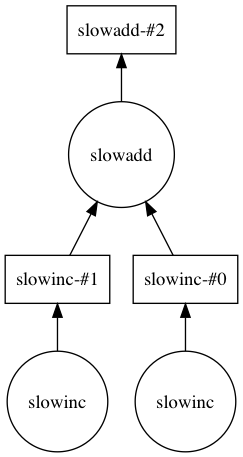

In [57]:
z.visualize()

# Parallelize a loop


In [58]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [59]:
%%time

results = []
for x in data:
    y = slowinc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 1.61 ms, sys: 1.91 ms, total: 3.52 ms
Wall time: 8.02 s


### Exercise 5.1

- Parallelize this by appending the delayed `slowinc` calls to the list `results`.
- Display the graph of `total` computation
- Compute time elapsed for the computation.

In [60]:
results = []
for x in data:
    y = delayed(slowinc)(x)
    results.append(y)
    
total = (delayed)(sum)(results)

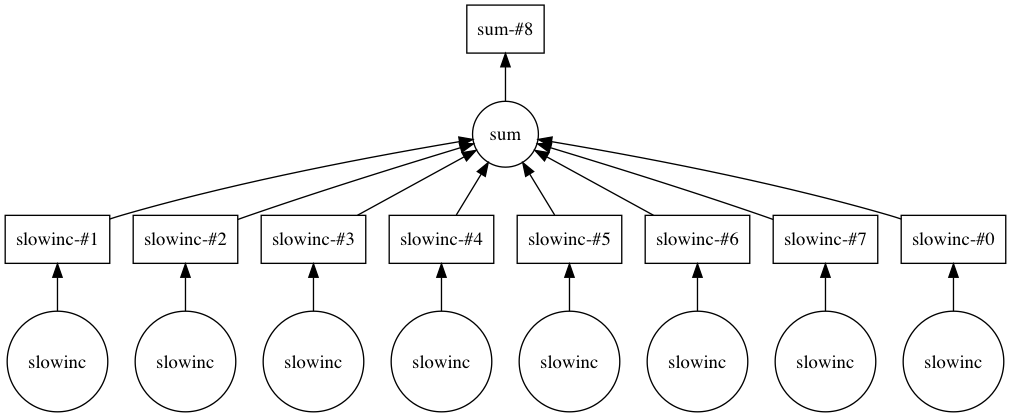

In [61]:
total.visualize()

In [62]:
%%time
total.compute()

CPU times: user 22.4 ms, sys: 30.3 ms, total: 52.6 ms
Wall time: 1.06 s


44

# Control flow
-  Delay only some functions, running a few of them immediately. This is helpful when those functions are fast and help us to determine what other slower functions we should call. 
- In the example below we iterate through a list of inputs. If that input is even then we want to call `half`. If the input is odd then we want to call `odd_process`. This iseven decision to call `half` or `odd_process` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.


In [63]:
from random import randint

def half(x):
    sleep(1)
    return x // 2

def odd_process(x):
    sleep(1)
    return 3*x+1

def is_even(x):
    return not x % 2

data = [randint(0,100) for i in range(8)]
data

[64, 60, 10, 19, 100, 98, 1, 43]

In [64]:
%%time
results = []
for x in data:
    if is_even(x):
        y = half(x)
    else:
        y = odd_process(x)
    results.append(y)
    
total = sum(results)
print(total)

358
CPU times: user 1.57 ms, sys: 1.56 ms, total: 3.14 ms
Wall time: 8.02 s


### Exercise 5.2
- Parallelize the sequential code above using dask.delayed
- You will need to delay some functions, but not all
- Visualize and check the computed result


### Exercise 5.3
- Parallelize the hdf5 conversion from json files
- Create a function `convert_to_hdf`
- Use dask.compute function on delayed calls of the funtion created list
- Is it really  faster as expected ?

In [65]:
import os, sys
from glob import glob
import pandas as pd

raw_data = {}
for year in range(2008,2017):

    fp = os.path.join("../data", f"nba-{year}.csv")

    if not os.path.exists(fp):
        url = f"http://www.basketball-reference.com/leagues/NBA_{year}_games.html"
        tables = pd.read_html(url)
        games = tables[0]
        games.to_csv(fp)
        raw_data[str(year)] = games
    else:
        raw_data[str(year)] = pd.read_csv(fp)

In [66]:
raw_data['2008'].head()

,Unnamed: 0,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes
0,0,"Tue, Oct 30, 2007",7:30 pm,Utah Jazz,117,Golden State Warriors,96,Box Score,NaN,19832,NaN
1,1,"Tue, Oct 30, 2007",7:30 pm,Houston Rockets,95,Los Angeles Lakers,93,Box Score,NaN,18997,NaN
2,2,"Tue, Oct 30, 2007",7:00 pm,Portland Trail Blazers,97,San Antonio Spurs,106,Box Score,NaN,18797,NaN
3,3,"Wed, Oct 31, 2007",8:00 pm,Dallas Mavericks,92,Cleveland Cavaliers,74,Box Score,NaN,20562,NaN
4,4,"Wed, Oct 31, 2007",8:30 pm,Seattle SuperSonics,103,Denver Nuggets,120,Box Score,NaN,19380,NaN


As you can see, we have some extra rows of mostly NaNs, the column names aren't useful, and we have some dtypes to fix up.

In [69]:
%%time 
seasons = {}
for year, games in raw_data.items():
    
    column_names = {'Date': 'date', 'Start (ET)': 'start',
                'Unamed: 2': 'box', 'Visitor/Neutral': 'away_team', 
                'PTS': 'away_points', 'Home/Neutral': 'home_team',
                'PTS.1': 'home_points', 'Unamed: 7': 'n_ot'}

    seasons[str(year)] = (games.rename(columns=column_names)
        .dropna(thresh=4)
        [['date', 'away_team', 'away_points', 'home_team', 'home_points']]
        .assign(date=lambda x: pd.to_datetime(x['date'], format='%a, %b %d, %Y'))
        .set_index('date', append=True)
        .rename_axis(["game_id", "date"])
        .sort_index())
    

CPU times: user 66.4 ms, sys: 6.6 ms, total: 73 ms
Wall time: 68 ms


In [70]:
seasons['2014']

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2013-10-29,Orlando Magic,87,Indiana Pacers,97
1,2013-10-29,Los Angeles Clippers,103,Los Angeles Lakers,116
2,2013-10-29,Chicago Bulls,95,Miami Heat,107
3,2013-10-30,Brooklyn Nets,94,Cleveland Cavaliers,98
...,...,...,...,...,...
15,2013-10-30,Boston Celtics,87,Toronto Raptors,93
16,2013-10-30,Oklahoma City Thunder,101,Utah Jazz,98
17,2013-10-31,New York Knicks,81,Chicago Bulls,82
18,2013-10-31,Golden State Warriors,115,Los Angeles Clippers,126


- `dropna` has a thresh argument. If at least thresh items are missing, the row is dropped. We used it to remove the "Month headers" that slipped into the table.
- `assign` can take a callable. This lets us refer to the DataFrame in the previous step of the chain. Otherwise we would have to assign temp_df = games.dropna()... And then do the pd.to_datetime on that.
-`set_index` has an append keyword. We keep the original index around since it will be our unique identifier per game.
- `.rename_axis` is used to set the index names.

### How many days of rest did each team get between each game?


In this case, an observation is a (team, game) pair, which we don't have yet. Rather, we have two observations per row, one for home and one for away. We'll fix that with `pd.melt`.

`pd.melt` works by taking observations that are spread across columns (away_team, home_team), and melting them down into one column with multiple rows. However, we don't want to lose the metadata (like game_id and date) that is shared between the observations. By including those columns as id_vars, the values will be repeated as many times as needed to stay with their observations.

In [81]:
%%time
### Parallel Code

import dask.bag as db

b = db.from_sequence(filenames)
series = b.map(lambda fn: pd.read_hdf(fn)['close'])

corr = (series.product(series)
              .filter(lambda ab: not (ab[0] == ab[1]).all())
              .map(lambda ab: ab[0].corr(ab[1])).max())

result = corr.compute()

CPU times: user 1.25 s, sys: 1.33 s, total: 2.57 s
Wall time: 5.35 s


# References
* [Dask website](https://dask.pydata.org/)
* [Modern Pandas (Part 5): Tidy Data by T. Augspurger](https://tomaugspurger.github.io/modern-5-tidy)
